**Load data through Drive:**


---



In [ ]:
file_path = '/content/drive/MyDrive/NYC TLC Trip Record Data/fhvhv_tripdata_2024-10.parquet'


# Big Data Cleaning:

**Performing EDA:**

In [ ]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("TaxiData").getOrCreate()

# Load Parquet dataset
df = spark.read.parquet('/content/drive/MyDrive/NYC TLC Trip Record Data/fhvhv_tripdata_2024-10.parquet')

# Show first few rows
df.show(5)

# Check row count
print("Total Rows:", df.count())


+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

*Checking shape of dataset:*

In [ ]:
import pandas as pd

df = pd.read_parquet('/content/drive/MyDrive/NYC TLC Trip Record Data/fhvhv_tripdata_2024-10.parquet')
print(df.head())
print("Shape:", df.shape)


  hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B03404               B03404   
1            HV0003               B03404               B03404   
2            HV0003               B03404               B03404   
3            HV0003               B03404               B03404   
4            HV0003               B03404               B03404   

     request_datetime   on_scene_datetime     pickup_datetime  \
0 2024-10-01 00:35:45 2024-10-01 00:38:27 2024-10-01 00:39:44   
1 2024-10-01 00:47:18 2024-10-01 00:51:47 2024-10-01 00:54:57   
2 2024-10-01 00:02:57 2024-10-01 00:04:48 2024-10-01 00:05:02   
3 2024-10-01 00:44:39 2024-10-01 00:47:12 2024-10-01 00:47:18   
4 2024-10-01 00:07:01 2024-10-01 00:12:16 2024-10-01 00:12:46   

     dropoff_datetime  PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0 2024-10-01 00:50:13           161           148        2.92  ...       1.77   
1 2024-10-01 01:06:18           148            87       

**Dataset is in parquet format because of big data requirment:**

In [ ]:
df = spark.read.parquet('/content/drive/MyDrive/NYC TLC Trip Record Data/fhvhv_tripdata_2024-10.parquet')


**Row count:**

In [ ]:
total_rows = df.count()
print("Total rows:", total_rows)

Total rows: 20028282


In [ ]:
df.columns


['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

**Removing null values:**

In [ ]:
from pyspark.sql import functions as F

# --- Step 1: Cast Numeric Columns Properly ---
numeric_cols = ['trip_miles', 'trip_time', 'base_passenger_fare', 'tolls',
                'sales_tax', 'congestion_surcharge', 'airport_fee',
                'tips', 'driver_pay', 'bcf']

for col in numeric_cols:
    df = df.withColumn(col, F.col(col).cast('double'))

# --- Step 2: Convert Datetime Columns ---
datetime_cols = ['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime']
for col in datetime_cols:
    df = df.withColumn(col, F.to_timestamp(col))

# --- Step 3: Drop Nulls in Key Columns ---
df_clean = df.dropna(subset=['pickup_datetime', 'dropoff_datetime', 'trip_miles', 'driver_pay', 'base_passenger_fare'])

# --- Step 4: Compute Trip Duration & Speed ---
df_clean = df_clean.withColumn(
    'trip_seconds',
    F.unix_timestamp('dropoff_datetime') - F.unix_timestamp('pickup_datetime')
).withColumn(
    'trip_hours',
    F.when(F.col('trip_seconds') > 0, F.col('trip_seconds') / 3600).otherwise(None)
).withColumn(
    'avg_speed_mph',
    F.when(F.col('trip_hours') > 0, F.col('trip_miles') / F.col('trip_hours')).otherwise(None)
)

# --- Step 5: Remove Impossible / Invalid Values ---
df_clean = df_clean.filter(
    (F.col('trip_miles') > 0) &
    (F.col('base_passenger_fare') > 0) &
    (F.col('driver_pay') > 0) &
    (F.col('trip_seconds') > 0) &
    (F.col('trip_seconds') < 24 * 3600) &
    (F.col('avg_speed_mph') < 120)
)

# --- Step 6: Add Total Fare Column ---
df_clean = df_clean.withColumn(
    'total_fare',
    F.col('base_passenger_fare') +
    F.col('tolls') +
    F.col('sales_tax') +
    F.col('congestion_surcharge') +
    F.col('airport_fee')
)

# --- Step 7: Add Time-Based Features (Fixed for Spark 3.x) ---
df_clean = df_clean.withColumn('pickup_hour', F.hour('pickup_datetime')) \
                   .withColumn('pickup_day', F.dayofmonth('pickup_datetime')) \
                   .withColumn('pickup_weekday', F.date_format('pickup_datetime', 'E')) \
                   .withColumn('weekday_num', F.dayofweek('pickup_datetime')) \
                   .withColumn('is_weekend',
                               F.when(F.col('weekday_num').isin([1, 7]), 1).otherwise(0))


# --- Step 8: Summary Output ---
print("✅ Cleaned dataset summary:")
print("Total rows after cleaning:", df_clean.count())
df_clean.printSchema()
df_clean.show(5)

✅ Cleaned dataset summary:
Total rows after cleaning: 20003981
root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp (nullable = true)
 |-- on_scene_datetime: timestamp (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: double (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_ma

# Big Data Analysis (Descriptive Insights):
**Trip Volume by Hour:**

+-----------+-------+
|pickup_hour|  count|
+-----------+-------+
|          0| 721197|
|          1| 497884|
|          2| 362341|
|          3| 298672|
|          4| 319510|
|          5| 371408|
|          6| 571964|
|          7| 884362|
|          8|1037823|
|          9| 933616|
|         10| 845163|
|         11| 818567|
|         12| 830344|
|         13| 862356|
|         14| 935198|
|         15| 969335|
|         16|1003771|
|         17|1115407|
|         18|1182857|
|         19|1175848|
|         20|1115187|
|         21|1090721|
|         22|1081757|
|         23| 978693|
+-----------+-------+



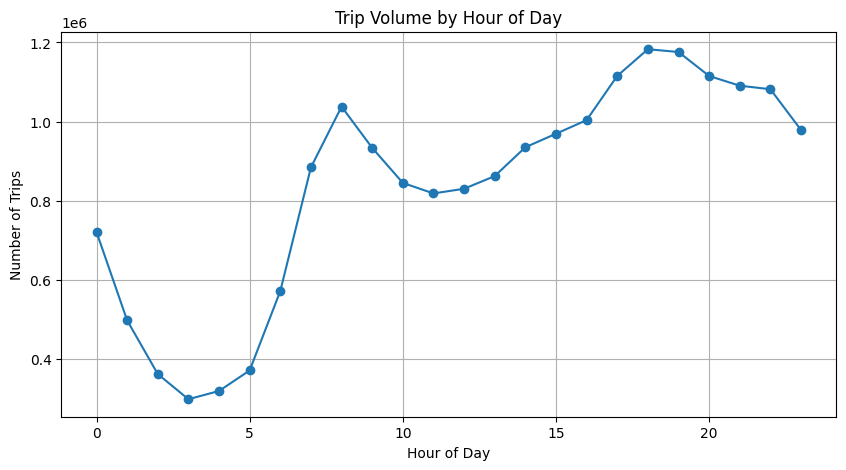

In [ ]:
# Aggregate trip counts by pickup hour
trips_by_hour = df_clean.groupBy("pickup_hour").count().orderBy("pickup_hour")
trips_by_hour.show(24)

# Convert to Pandas for plotting
pdf_hour = trips_by_hour.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(pdf_hour["pickup_hour"], pdf_hour["count"], marker="o")
plt.title("Trip Volume by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.show()


**Average Fare vs Distance:**

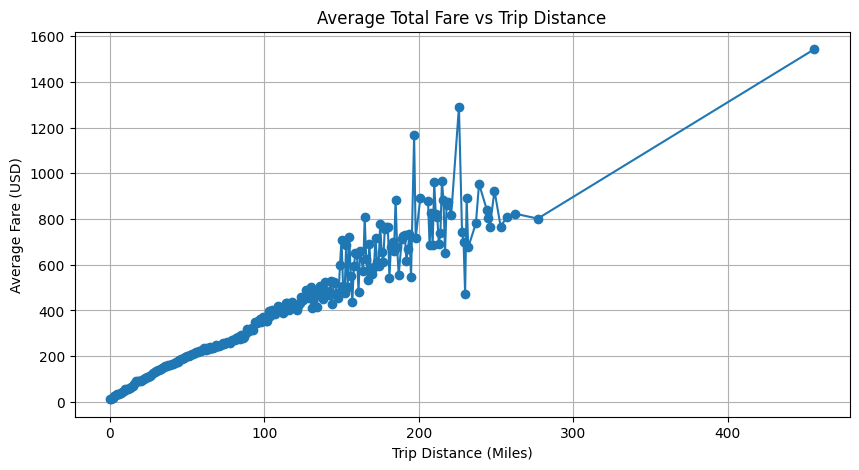

In [ ]:
# Average fare for each distance band
df_fare_dist = df_clean.withColumn("distance_band", F.round(F.col("trip_miles")))
avg_fare = df_fare_dist.groupBy("distance_band") \
    .agg(F.avg("total_fare").alias("avg_total_fare")) \
    .orderBy("distance_band")

pdf_fare = avg_fare.toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_fare["distance_band"], pdf_fare["avg_total_fare"], marker="o")
plt.title("Average Total Fare vs Trip Distance")
plt.xlabel("Trip Distance (Miles)")
plt.ylabel("Average Fare (USD)")
plt.grid(True)
plt.show()


**Company Market Share (Uber vs Lyft):**

+-----------------+--------+
|hvfhs_license_num|   count|
+-----------------+--------+
|           HV0003|15121300|
|           HV0005| 4882681|
+-----------------+--------+



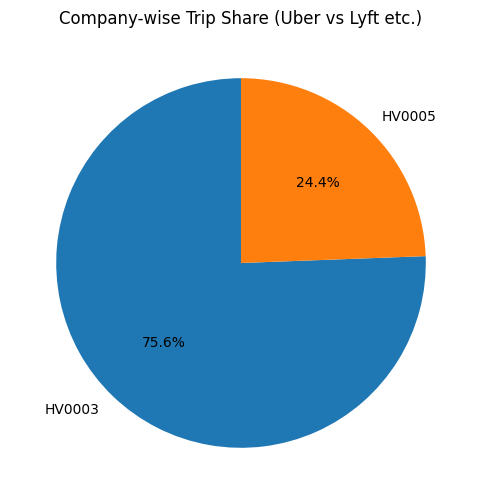

In [ ]:
company_counts = df_clean.groupBy("hvfhs_license_num").count().orderBy(F.desc("count"))
company_counts.show()

pdf_company = company_counts.toPandas()

plt.figure(figsize=(6,6))
plt.pie(pdf_company["count"], labels=pdf_company["hvfhs_license_num"], autopct="%1.1f%%", startangle=90)
plt.title("Company-wise Trip Share (Uber vs Lyft etc.)")
plt.show()


**Average Driver Pay by Day of Week:**

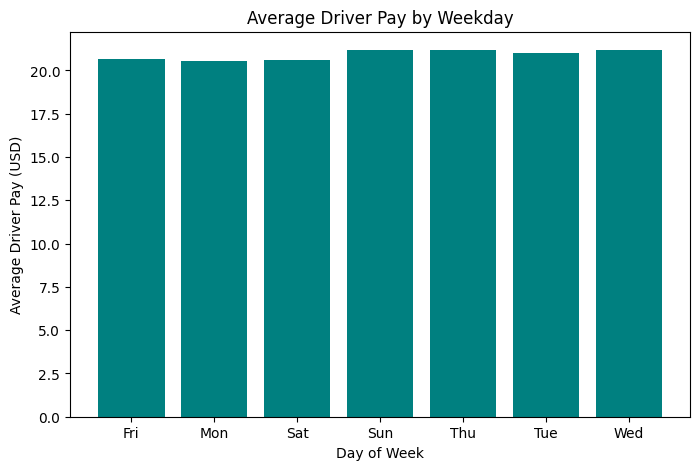

In [ ]:
avg_pay_day = df_clean.groupBy("pickup_weekday") \
    .agg(F.avg("driver_pay").alias("avg_driver_pay")) \
    .orderBy("pickup_weekday")

pdf_pay_day = avg_pay_day.toPandas()

plt.figure(figsize=(8,5))
plt.bar(pdf_pay_day["pickup_weekday"], pdf_pay_day["avg_driver_pay"], color="teal")
plt.title("Average Driver Pay by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Average Driver Pay (USD)")
plt.show()


**Correlation Heatmap:**

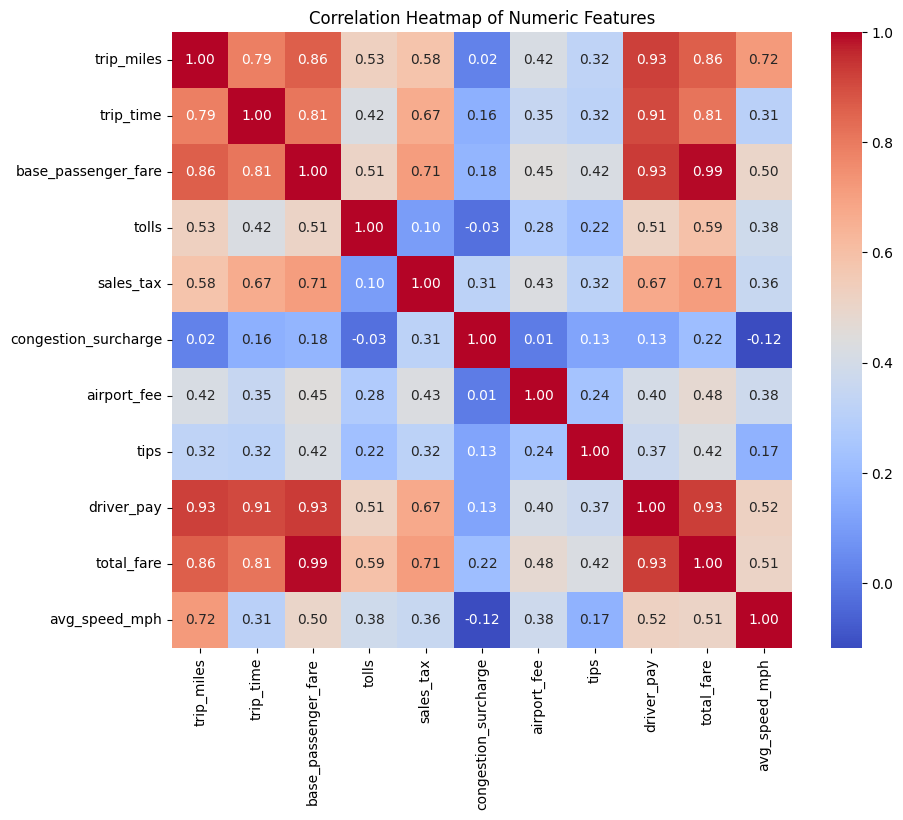

In [ ]:
pdf_corr = df_clean.select(
    "trip_miles","trip_time","base_passenger_fare","tolls",
    "sales_tax","congestion_surcharge","airport_fee",
    "tips","driver_pay","total_fare","avg_speed_mph"
).sample(0.001).toPandas()  # small random sample to avoid memory issue

corr = pdf_corr.corr()

import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


**Creating directory to save the model:**

In [ ]:
import os

# Define output directory path inside Google Drive
MODEL_OUT_DIR = '/content/drive/MyDrive/data/analysis/model'

# Automatically create directory (and parent folders) if not exist
os.makedirs(MODEL_OUT_DIR, exist_ok=True)

print(f"✅ Model output directory ready at: {MODEL_OUT_DIR}")


✅ Model output directory ready at: /content/drive/MyDrive/data/analysis/model


# ANN training: predict total_fare (Keras):

Total rows in Spark cleaned DF: 20003981
Sampling fraction for Pandas: 0.012497512370162719
Sampled pandas shape: (251237, 33)
After dropna shape: (251237, 15)
Final training dataframe shape: (251237, 18)
Feature names: ['trip_miles', 'trip_seconds', 'pickup_hour', 'is_weekend', 'avg_speed_mph', 'tips', 'tolls', 'congestion_surcharge', 'airport_fee', 'bcf', 'sales_tax', 'PULocationID_fare_mean', 'DOLocationID_fare_mean', 'company_freq']
X shape: (251237, 14) y shape: (251237, 1)
Train / val / test shapes: (200989, 14) (25124, 14) (25124, 14)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


197/197 - 7s - 36ms/step - loss: 358.4267 - mae: 10.3727 - rmse: 18.9322 - val_loss: 29.1905 - val_mae: 3.6637 - val_rmse: 5.4028
Epoch 2/100


197/197 - 1s - 3ms/step - loss: 27.3535 - mae: 3.2895 - rmse: 5.2301 - val_loss: 9.2941 - val_mae: 1.8572 - val_rmse: 3.0486
Epoch 3/100


197/197 - 1s - 3ms/step - loss: 17.5151 - mae: 2.5130 - rmse: 4.1851 - val_loss: 5.8963 - val_mae: 1.3848 - val_rmse: 2.4282
Epoch 4/100


197/197 - 1s - 3ms/step - loss: 14.5747 - mae: 2.2198 - rmse: 3.8177 - val_loss: 4.8139 - val_mae: 1.2137 - val_rmse: 2.1941
Epoch 5/100


197/197 - 1s - 3ms/step - loss: 12.9102 - mae: 2.0310 - rmse: 3.5931 - val_loss: 4.2471 - val_mae: 1.1283 - val_rmse: 2.0609
Epoch 6/100
197/197 - 1s - 3ms/step - loss: 11.9527 - mae: 1.9028 - rmse: 3.4573 - val_loss: 4.4280 - val_mae: 1.1652 - val_rmse: 2.1043
Epoch 7/100


197/197 - 1s - 3ms/step - loss: 11.1227 - mae: 1.7987 - rmse: 3.3351 - val_loss: 3.5903 - val_mae: 0.9784 - val_rmse: 1.8948
Epoch 8/100


197/197 - 1s - 3ms/step - loss: 10.7210 - mae: 1.7235 - rmse: 3.2743 - val_loss: 3.3614 - val_mae: 0.9531 - val_rmse: 1.8334
Epoch 9/100
197/197 - 1s - 3ms/step - loss: 10.2161 - mae: 1.6776 - rmse: 3.1963 - val_loss: 3.5226 - val_mae: 0.9950 - val_rmse: 1.8769
Epoch 10/100


197/197 - 1s - 3ms/step - loss: 9.6536 - mae: 1.6058 - rmse: 3.1070 - val_loss: 3.3295 - val_mae: 0.9872 - val_rmse: 1.8247
Epoch 11/100
197/197 - 1s - 3ms/step - loss: 9.4808 - mae: 1.5645 - rmse: 3.0791 - val_loss: 4.5487 - val_mae: 1.1663 - val_rmse: 2.1328
Epoch 12/100


197/197 - 1s - 3ms/step - loss: 9.2171 - mae: 1.5372 - rmse: 3.0360 - val_loss: 2.9420 - val_mae: 0.8753 - val_rmse: 1.7152
Epoch 13/100
197/197 - 1s - 3ms/step - loss: 8.9272 - mae: 1.5055 - rmse: 2.9878 - val_loss: 3.0573 - val_mae: 0.9052 - val_rmse: 1.7485
Epoch 14/100


197/197 - 1s - 3ms/step - loss: 8.6587 - mae: 1.4740 - rmse: 2.9426 - val_loss: 2.8965 - val_mae: 0.9153 - val_rmse: 1.7019
Epoch 15/100
197/197 - 1s - 3ms/step - loss: 8.4461 - mae: 1.4407 - rmse: 2.9062 - val_loss: 4.3414 - val_mae: 1.1366 - val_rmse: 2.0836
Epoch 16/100
197/197 - 1s - 4ms/step - loss: 8.2111 - mae: 1.4145 - rmse: 2.8655 - val_loss: 4.1358 - val_mae: 1.1410 - val_rmse: 2.0337
Epoch 17/100
197/197 - 1s - 6ms/step - loss: 8.0600 - mae: 1.3886 - rmse: 2.8390 - val_loss: 2.9497 - val_mae: 0.9758 - val_rmse: 1.7175
Epoch 18/100
197/197 - 1s - 4ms/step - loss: 7.9328 - mae: 1.3589 - rmse: 2.8165 - val_loss: 2.9247 - val_mae: 0.9832 - val_rmse: 1.7102
Epoch 19/100
197/197 - 1s - 3ms/step - loss: 7.7328 - mae: 1.3302 - rmse: 2.7808 - val_loss: 3.9709 - val_mae: 1.2086 - val_rmse: 1.9927
Epoch 20/100
197/197 - 1s - 3ms/step - loss: 7.6606 - mae: 1.3149 - rmse: 2.7678 - val_loss: 3.5751 - val_mae: 1.1492 - val_rmse: 1.8908
Test metrics (loss, rmse, mae): [3.4691121578216553, 1

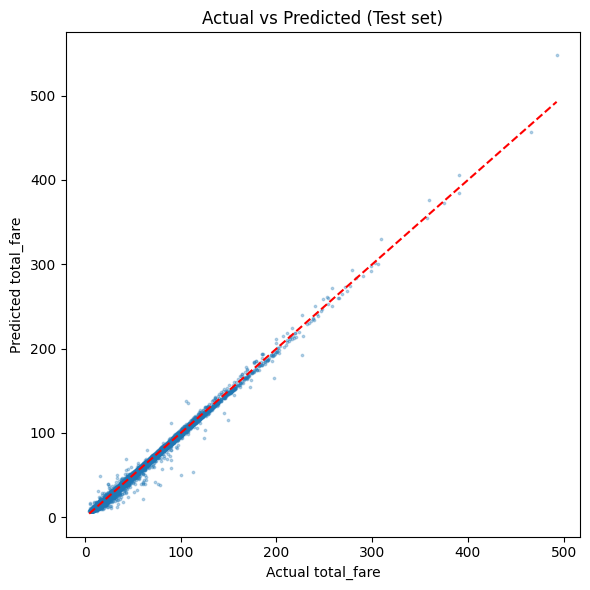

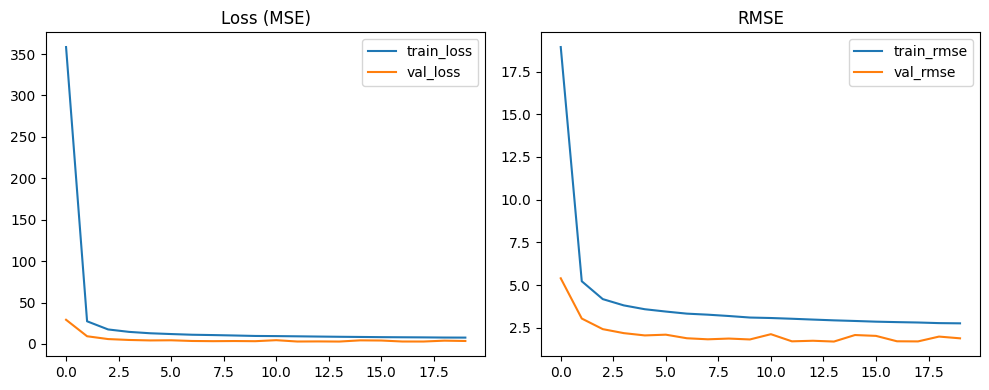

Model and artifacts saved to: /content/drive/MyDrive/data/analysis/model
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                   feature  importance_delta_mse
9                      bcf            629.722132
10               sales_tax            153.782179
6                    tolls             23.232892
0               trip_miles             17.870463
1             trip_seconds             10.089871
7     congestion_s

In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1) Parameters
SAMPLE_MAX = 250_000         # sample rows for training (adjust if memory allows)
RANDOM_SEED = 42
TARGET = 'total_fare'        # target column (use 'driver_pay' if you prefer)
MODEL_OUT_DIR = '/content/drive/MyDrive/data/analysis/model'
os.makedirs(MODEL_OUT_DIR, exist_ok=True)

# 2) Sample data from Spark to Pandas (memory-safe)
n_rows = df_clean.count()
frac = min(SAMPLE_MAX / n_rows, 1.0)
print("Total rows in Spark cleaned DF:", n_rows)
print("Sampling fraction for Pandas:", frac)

pdf = df_clean.sample(withReplacement=False, fraction=frac, seed=RANDOM_SEED).toPandas()
print("Sampled pandas shape:", pdf.shape)

# 3) Basic filtering & drop NA for chosen target/features
# Choose features (numeric + engineered). You can add/remove as needed.
features = [
    'trip_miles', 'trip_seconds', 'pickup_hour', 'is_weekend',
    'avg_speed_mph', 'tips', 'tolls', 'congestion_surcharge',
    'airport_fee', 'bcf', 'sales_tax'
]
# We'll add frequency-encoded PULocationID & DOLocationID
cat_cols = ['PULocationID', 'DOLocationID', 'hvfhs_license_num']  # hvfhs used as company ID

needed_cols = features + cat_cols + [TARGET]
pdf = pdf[needed_cols].copy()
pdf = pdf.dropna(subset=[TARGET] + features)  # drop rows missing target or numeric features
print("After dropna shape:", pdf.shape)

# 4) Frequency encoding for high-cardinality categorical IDs
# PULocationID and DOLocationID -> encode by mean total_fare or by frequency
# We'll do mean-target encoding for location IDs (more informative)
for col in ['PULocationID', 'DOLocationID']:
    # compute mean target per ID
    mapping = pdf.groupby(col)[TARGET].mean().rename(f'{col}_fare_mean')
    pdf = pdf.join(mapping, on=col, how='left')
    # Use that new column as a numeric feature
    features.append(f'{col}_fare_mean') # Corrected column name here

# For hvfhs_license_num (company), do frequency encoding (proportion of trips)
company_freq = pdf['hvfhs_license_num'].value_counts(normalize=True).rename('company_freq')
pdf = pdf.join(company_freq, on='hvfhs_license_num', how='left')
features.append('company_freq')

# 5) Final clean: drop any remaining NA feature rows and ensure positive targets
pdf = pdf.dropna(subset=features + [TARGET])
pdf = pdf[pdf[TARGET] > 0]
print("Final training dataframe shape:", pdf.shape)

# 6) Prepare X and y
X = pdf[features].values
y = pdf[TARGET].values.reshape(-1, 1)

print("Feature names:", features)
print("X shape:", X.shape, "y shape:", y.shape)

# 7) Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

print("Train / val / test shapes:", X_train.shape, X_val.shape, X_test.shape)

# 8) Scale features (StandardScaler fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Save scaler for later reuse
import joblib
joblib.dump(scaler, os.path.join(MODEL_OUT_DIR, 'scaler.gz'))

# 9) Build the Keras model (simple, effective)
def build_model(input_dim):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(input_dim,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='linear')  # regression output
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=[keras.metrics.RootMeanSquaredError(name='rmse'),
                           keras.metrics.MeanAbsoluteError(name='mae')])
    return model

model = build_model(X_train_s.shape[1])
model.summary()

# 10) Callbacks: EarlyStopping + ModelCheckpoint
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(os.path.join(MODEL_OUT_DIR, 'best_model.h5'), save_best_only=True, monitor='val_loss')
]

# 11) Train
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=callbacks,
    verbose=2
)

# 12) Evaluate on test set
test_metrics = model.evaluate(X_test_s, y_test, verbose=0)
print("Test metrics (loss, rmse, mae):", test_metrics)

# Convert to readable metrics
test_rmse = test_metrics[1]
test_mae = test_metrics[2]
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")

# 13) Predictions & scatter plot (actual vs predicted)
y_pred = model.predict(X_test_s).flatten()
plt.figure(figsize=(6,6))
plt.scatter(y_test.flatten(), y_pred, s=3, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual total_fare")
plt.ylabel("Predicted total_fare")
plt.title("Actual vs Predicted (Test set)")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_OUT_DIR, 'actual_vs_predicted.png'))
plt.show()

# 14) Training history plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss (MSE)')
plt.subplot(1,2,2)
plt.plot(history.history['rmse'], label='train_rmse')
plt.plot(history.history['val_rmse'], label='val_rmse')
plt.legend(); plt.title('RMSE')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_OUT_DIR, 'training_history.png'))
plt.show()

# 15) Save the final model (HDF5 or SavedModel)
model.save(os.path.join(MODEL_OUT_DIR, 'final_model.keras'))   # SavedModel format
print("Model and artifacts saved to:", MODEL_OUT_DIR)

# 16) Feature importance (rough) using permutation importance on a small subset (optional)
try:
    from sklearn.inspection import permutation_importance
    # use a small subset to compute importance
    X_test_sub = X_test_s[:20000]
    y_test_sub = y_test[:20000].ravel()
    def model_predict(Xi):
        return model.predict(Xi).ravel()
    # Use sklearn's permutation importance wrapper with a dummy estimator:
    # We compute baseline predictions and then permute columns
    baseline_preds = model_predict(X_test_sub)
    baseline_mse = np.mean((baseline_preds - y_test_sub)**2)
    importances = []
    for i in range(X_test_sub.shape[1]):
        X_perm = X_test_sub.copy()
        np.random.RandomState(RANDOM_SEED).shuffle(X_perm[:, i])
        preds = model_predict(X_perm)
        mse_perm = np.mean((preds - y_test_sub)**2)
        importances.append(mse_perm - baseline_mse)
    feat_importance = pd.DataFrame({'feature': features, 'importance_delta_mse': importances})
    feat_importance = feat_importance.sort_values('importance_delta_mse', ascending=False)
    print(feat_importance)
    feat_importance.to_csv(os.path.join(MODEL_OUT_DIR, 'feature_importance_perm.csv'), index=False)
except Exception as e:
    print("Permutation importance failed (optional).", e)